## Digit Recognition - Logistic Regression on MNIST  using STAN

This notebook shows how to perform simple digit classification on the MNIST digits dataset using STAN. We will first use sklearn's Logistic Regression to fit and evaluate the classifier's performance and then we will use STAN for the same task to give it the full bayesian approach.


In [35]:
import sklearn
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

We will first load the digits dataset which contains 4 bit grayscale images of size 8x8 pixels (64 pixels flattened) and plot the first few images. We will normalize the image data and index the labels from 1 rather than 0. The data consists of 1797 images in total

In [2]:
X,y = load_digits(return_X_y=True)
# Normalize image data
X = X/16
# Index labels from 1
y = y+1

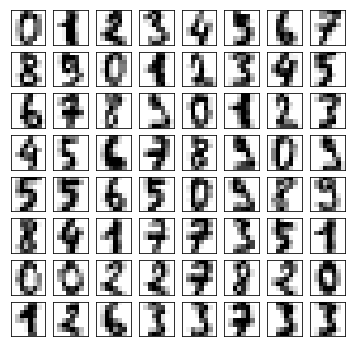

In [3]:
fig,axes = plt.subplots(8,8,figsize=(6,6))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8,8),cmap=plt.cm.gray_r)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
y

array([ 1,  2,  3, ...,  9, 10,  9])

In [5]:
X.shape

(1797, 64)

### Logistic Regression using sklearn (MLE Estimate)

In [6]:
lr=LogisticRegression()
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
y_pred = lr.predict(X)

In [8]:
print(accuracy_score(y, y_pred))

0.974958263773


### Logistic Regression using STAN (Bayesian Logistic Regression)

In [9]:
import pystan
import numpy as np
import stan_utility
from collections import OrderedDict

#### Stan (2.1.6) Code for Logistic Regression on MNIST

The categorical_logit_rng function is not available for earlier versions of STAN (2.1.14) which seems to be the default when doing conda install pystan. I installed pystan from pip which gets me the latest version (2.1.16) but I had to do conda install gcc to prevent compilation issues on Linux

In [10]:
mnist_code = '''
data {

int<lower=1> N;
int<lower=1> D;
matrix[N,D] X;
int<lower=1> K;
int y[N];

}

parameters {

matrix[K,D] beta;
real alpha;

}

model {

  alpha ~ normal(0,5);
  for(k in 1:K)
      beta[k] ~ normal(0,5);
  for(n in 1:N) {
      y[n] ~ categorical_logit(beta*X[n]' + alpha);
  }
}

generated quantities {
  vector[N] y_pred;
  for(n in 1:N) {
      y_pred[n] = categorical_logit_rng(beta*X[n]' + alpha);
  }
}

'''

In [11]:
data = OrderedDict({'X':X, 'y':y, 'N': X.shape[0],'D':X.shape[1],'K':10})

### Fitting the Model

In [18]:
model = pystan.StanModel(model_code=mnist_code,model_name='mnist1',verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL mnist1_2b7b3fcaed726c8ce874b4512c336943 NOW.
INFO:pystan:OS: linux, Python: 3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.26


Compiling /tmp/tmpxz51byiu/stanfit4mnist1_2b7b3fcaed726c8ce874b4512c336943_948423228813126516.pyx because it changed.
[1/1] Cythonizing /tmp/tmpxz51byiu/stanfit4mnist1_2b7b3fcaed726c8ce874b4512c336943_948423228813126516.pyx
building 'stanfit4mnist1_2b7b3fcaed726c8ce874b4512c336943_948423228813126516' extension
creating /tmp/tmpxz51byiu/tmp
creating /tmp/tmpxz51byiu/tmp/tmpxz51byiu
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpxz51byiu -I/home/aravind/anaconda3/envs/pystanenv/lib/python3.6/site-packages/pystan -I/home/aravind/anaconda3/envs/pystanenv/lib/python3.6/site-packages/pystan/stan/src -I/home/aravind/anaconda3/envs/pystanenv/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/home/aravind/anaconda3/envs/pystanenv/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/home/aravind/anaconda3/envs/pystanenv/lib/python3.6/site-packages/pystan/

With the model and data specified we can now turn to Stan to quantify the resulting posterior distribution with Hamiltonian Monte Carlo,

In [19]:
fit = model.sampling(data=data, seed=42)

#### Unfortunately sampling took close to 95 minutes for this model and data

In [20]:
print(fit)

Inference for Stan model: mnist1_2b7b3fcaed726c8ce874b4512c336943.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.04    0.08   4.95  -9.78  -3.38  -0.02   3.23   9.73   4000    1.0
beta[1,0]      0.07    0.08    5.0   -9.6  -3.34   0.12   3.36  10.13   4000    1.0
beta[2,0]      0.02    0.08   4.97  -9.39  -3.34  -0.07   3.44   9.83   4000    1.0
beta[3,0]      0.14    0.08   5.06 -10.08  -3.22   0.07   3.55  10.09   4000    1.0
beta[4,0]     -0.06    0.08   5.04  -9.98  -3.46  -0.06   3.27  10.13   4000    1.0
beta[5,0]      0.04    0.08   5.05   -9.6  -3.37   0.04   3.46   9.86   4000    1.0
beta[6,0]     -0.01    0.08   4.93  -9.74  -3.43 1.6e-3   3.31   9.69   4000    1.0
beta[7,0]     -0.02    0.08   4.95  -9.45   -3.4-2.5e-3   3.34   9.71   4000    1.0
beta[8,0]     -0.03    0.08   5.04  -9.96  -3.36  -0.06   3

### Validate fit and check for divergences

In [21]:
stan_utility.check_treedepth(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [25]:
stan_utility.check_div(fit)

0.0 of 4000 iterations ended with a divergence (0.0%)


### Check predictions and model accuracy

In [26]:
y_pred=fit.extract('y_pred')

In [27]:
y_pred=y_pred['y_pred']

In [28]:
np.shape(y_pred)

(4000, 1797)

In [29]:
accuracy_scores = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
    accuracy_scores[i] = (accuracy_score(y_pred[i], y))

In [31]:
print(np.mean(accuracy_scores))

0.974598636617


In [32]:
print(np.std(accuracy_scores))

0.00354480609743


This exercise was just to demonstrate use of STAN in a common machine learning task. The full bayesian approach might seem to be an overkill for a similar level of accuracy score but we get a distribution over parameters and distribution over predictions

#### Platform

In [38]:
print("Numpy Version:",np.__version__)
print("Pystan Version:", pystan.__version__)
print("Matplotlib Version:", matplotlib.__version__)
print("Scikit-learn Version:",sklearn.__version__)

Numpy Version: 1.13.1
Pystan Version: 2.16.0.0
Matplotlib Version: 2.0.2
Scikit-learn Version: 0.19.0
